# 1. IMPORTACOES

## 1.1 Funcoes de Ajuda

In [100]:
import pandas     as pd
import numpy      as np
import seaborn    as sns
import inflection
import math
from matplotlib import pyplot as plt
from IPython.core.display import HTML
from IPython.display import Image
import datetime

def jupyter_settings():
    %matplotlib inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
    
jupyter_settings()


ModuleNotFoundError: No module named 'datatime'

## 1.2 Carregamento dos Dados

In [3]:
df_sales_raw = pd.read_csv( 'datas/train.csv' , low_memory=False )
df_store_raw = pd.read_csv( 'datas/store.csv' , low_memory=False )

In [4]:
# Juntar os dois dataframes
df_raw = pd.merge( df_sales_raw , df_store_raw , how='left' , on='Store')

# 2. DESCRICAO DOS DADOS

## 2.1 Renomeacao das Colunas

In [5]:
# Extracao das descricoes das colunas
df1 = df_raw.copy()
cols_old = df1.columns

In [6]:
# Alteracao dos nomes das colunas, incluindo um '_'
snakecase = lambda x : inflection.underscore(x)
cols_new = list( map( snakecase, cols_old ) )
df1.columns = cols_new

## 2.2 Dimensoes dos Dados

In [7]:
print( "Numero de linhas: {}".format(df1.shape[0]) )
print( "Numero de colunas: {}".format(df1.shape[1]) )

Numero de linhas: 1017209
Numero de colunas: 18


## 2.3 Tipos dos Dados

In [8]:
df1['date'] = pd.to_datetime( df1['date'] )
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 2.4 Verificacao e Tratamento dos NAs

In [9]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

In [52]:
# competition_distance
df1['competition_distance'] = df1['competition_distance'].apply( lambda x : 100000.0 if math.isnan( x ) else x )

# competition_open_since_month
df1['competition_open_since_month'] = df1.apply( lambda w: w['date'].month if math.isnan( w['competition_open_since_month'] ) else w['competition_open_since_month'], axis=1 )

# competition_open_since_year
df1['competition_open_since_year'] = df1.apply( lambda w: w['date'].year if math.isnan( w['competition_open_since_year'] ) else w['competition_open_since_year'], axis=1 )

# promo2_since_week
df1['promo2_since_week'] = df1.apply( lambda w: w['date'].week if math.isnan( w['promo2_since_week'] ) else w['promo2_since_week'], axis=1 )

# promo2_since_year
df1['promo2_since_year'] = df1.apply( lambda w: w['date'].year if math.isnan( w['promo2_since_year'] ) else w['promo2_since_year'], axis=1 )

# promo_interval
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
df1['promo_interval'].fillna(0, inplace=True)
df1['month_map'] = df1['date'].dt.month.map( month_map )
df1['is_promo'] = df1[['promo_interval','month_map']].apply(lambda y: 0 if y['promo_interval']==0 else 1 if y['month_map'] in y['promo_interval'].split(',') else 0 , axis=1 )

In [54]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 2.5 Alteracao dos Tipos de Dados

In [55]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

In [56]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int32
competition_open_since_year              int32
promo2                                   int64
promo2_since_week                        int32
promo2_since_year                        int32
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

# 3. Estatistica Descritiva

In [61]:
num_attributes = df1.select_dtypes( include=['int32','int64','float64'] )
cat_attributes = df1.select_dtypes( exclude=['int32','int64','float64','datetime64[ns]'] )

## 3.1 Atributos Numericos

In [68]:
# Tendencias Centrais
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Medidas de Dispersao
d1 = pd.DataFrame( num_attributes.apply(np.std) ).T
d2 = pd.DataFrame( num_attributes.apply(min) ).T
d3 = pd.DataFrame( num_attributes.apply(max) ).T
d4 = pd.DataFrame( num_attributes.apply(lambda x: x.max() - x.min()) ).T
d5 = pd.DataFrame( num_attributes.apply(lambda x: x.skew()) ).T
d6 = pd.DataFrame( num_attributes.apply(lambda x: x.kurtosis()) ).T

# Uniao dos dataframes
metrics = pd.concat( [d2,d3,d4,ct1,ct2,d1,d5,d6] ).T.reset_index()
metrics.columns = ['atributos','min','max','interv','media','mediana','devpad','skew','curtosis']

In [69]:
metrics

,atributos,min,max,interv,media,mediana,devpad,skew,curtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,100000.0,99980.0,5675.712376,2330.0,9085.159292,4.637208,35.287543
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


## 3.2 Atributos Categoricos

In [70]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

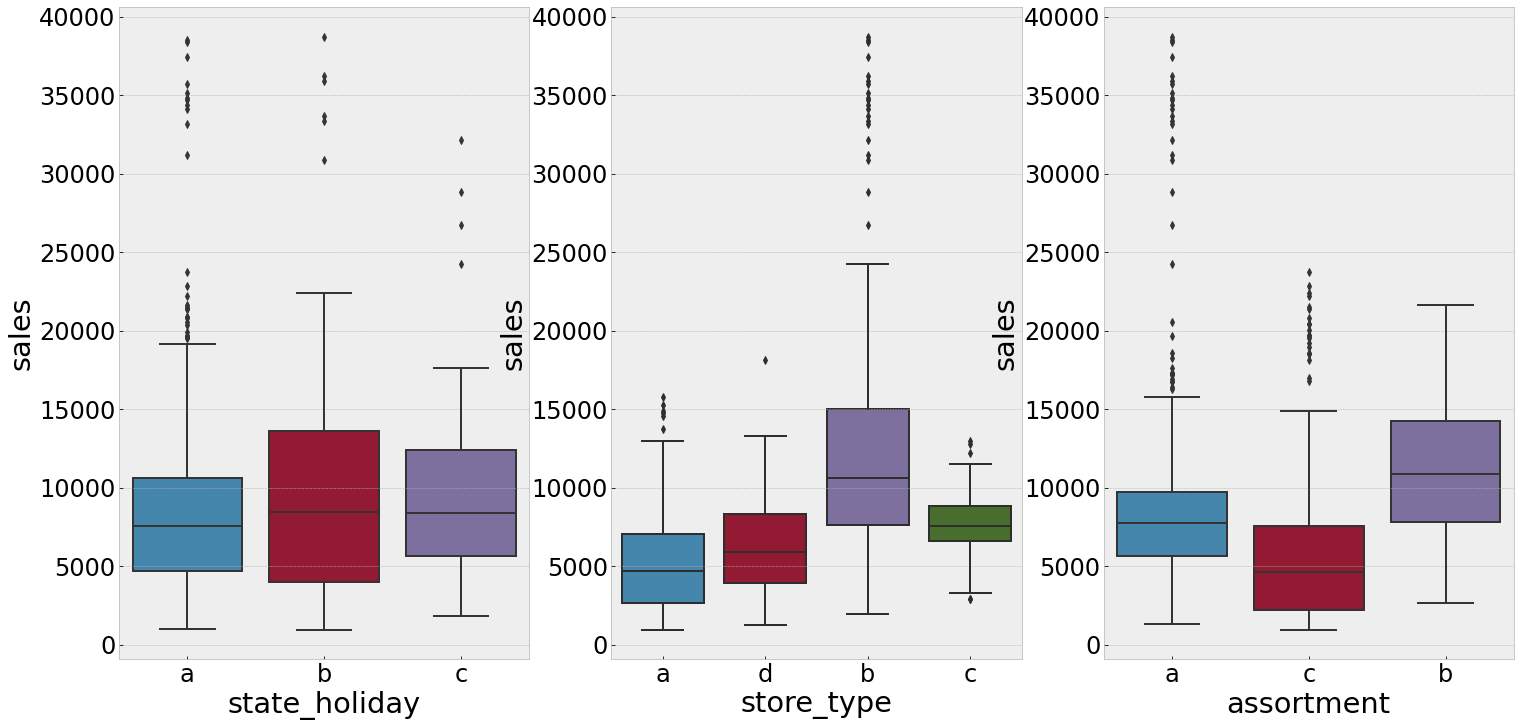

In [80]:
aux1 = df1[(df1['state_holiday']!='0') & (df1['sales']>0)]

plt.subplot(1,3,1)
sns.boxplot( x='state_holiday' ,y='sales', data=aux1 )

plt.subplot(1,3,2)
sns.boxplot( x='store_type' ,y='sales', data=aux1 )

plt.subplot(1,3,3)
sns.boxplot( x='assortment' ,y='sales', data=aux1 )

# 4. ENGENHARIA DE CARACTERISTICAS (Feature Engineering)

## 4.1 Mapa Mental das Hipoteses

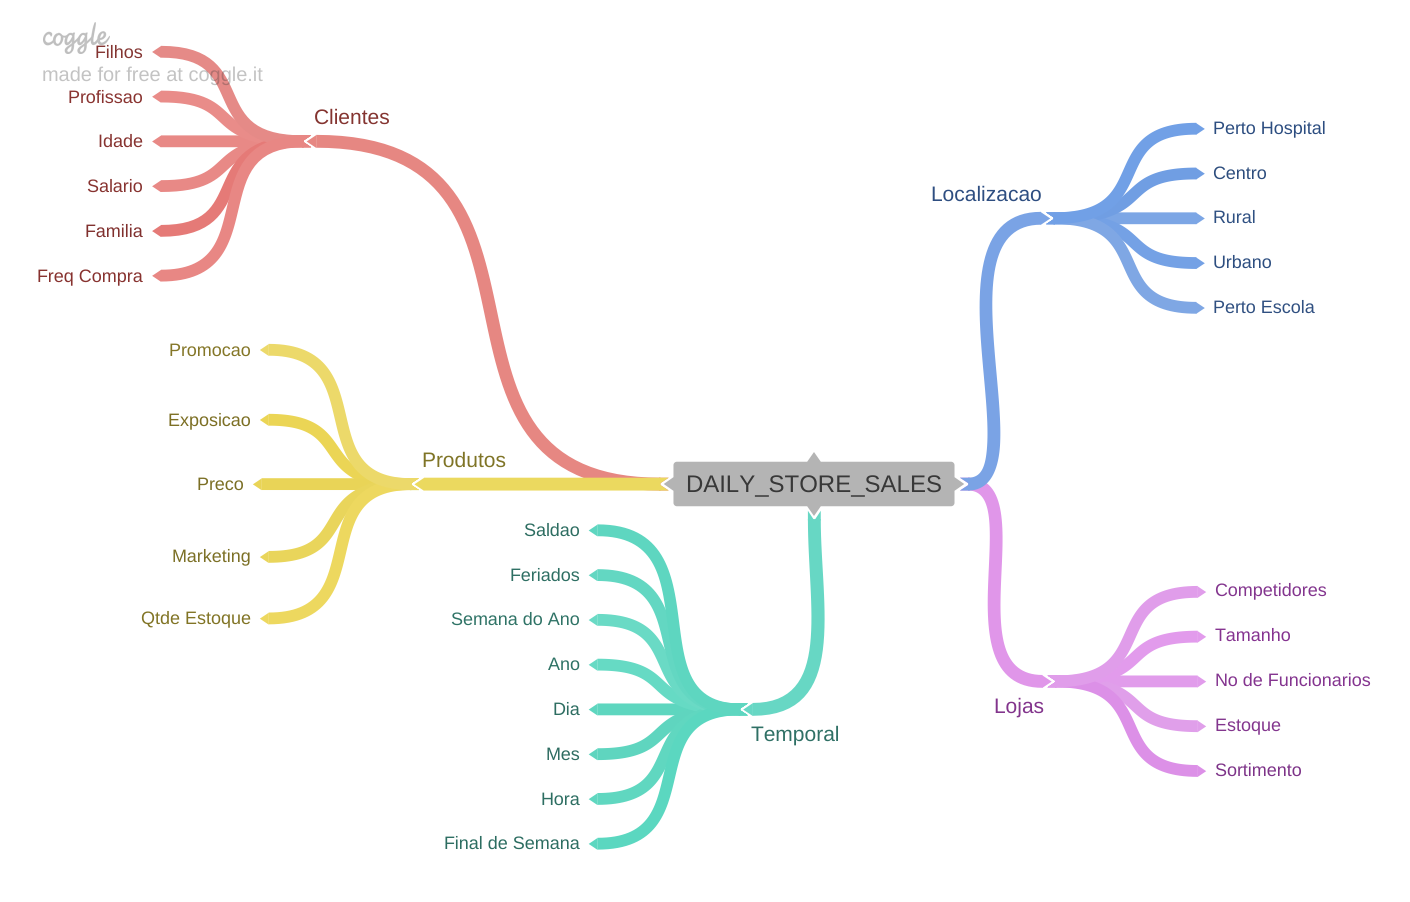

In [83]:
Image( 'datas\daily_store_sales.png')

## 4.2 Criacao das Hipoteses

### 4.2.1 Hipoteses do item Loja

**1.** Lojas com maior quadro de funcionarios deveriam vender mais.</br>
**2.** Lojas com maior estoque deveriam vender mais.</br>
**3.** Lojas com maior porte deveriam vender mais.</br>
**4.** Lojas com maior sortimento deveriam vender mais.</br>
**5.** Lojas com competidores mais proximos deveriam vender menos.</br>
**6.** Lojas com competidores a mais tempo deveriam vender mais.

### 4.2.2 Hipoteses do item Produto

**1.** Lojas com produtos com preco menor deveriam vender mais.</br>
**2.** Lojas com promocoes mais agressivas deveriam vender mais.</br>
**3.** Lojas com promocoes ativas por mais tempo deveriam vender mais.</br>
**4.** Lojas com mais dias de promocao deveriam vender mais.</br>
**5.** Lojas com promocoes mais consecutivas deveriam vender mais.

### 4.2.3 Hipoteses do item Tempo

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.</br>
**2.** Lojas deveriam vender mais ao longo dos anos.</br>
**3.** Lojas deveriam vender mais no segundo semestre do ano.</br>
**4.** Lojas deveriam vender mais depois do dia 10 de cada mes.</br>
**5.** Lojas deveriam vender menos aos finais-de-semana.</br>
**6.** Lojas deveriam vender menos durante os feriados escolares.

## 4.3 Lista Final de Hipoteses

**LOJAS**</br>
**1.** Lojas com maior sortimento deveriam vender mais.</br>
**2.** Lojas com competidores mais proximos deveriam vender menos.</br>
**3.** Lojas com competidores a mais tempo deveriam vender mais.

**PRODUTOS**</br>
**4.** Lojas com promocoes ativas por mais tempo deveriam vender mais.</br>
**5.** Lojas com mais dias de promocao deveriam vender mais.</br>
**6.** Lojas com promocoes mais consecutivas deveriam vender mais.

**TEMPO**</br>
**7.** Lojas abertas durante o feriado de Natal deveriam vender mais.</br>
**8.** Lojas deveriam vender mais ao longo dos anos.</br>
**9.** Lojas deveriam vender mais no segundo semestre do ano.</br>
**10.** Lojas deveriam vender mais depois do dia 10 de cada mes.</br>
**11.** Lojas deveriam vender menos aos finais-de-semana.</br>
**12.** Lojas deveriam vender menos durante os feriados escolares.

## 4.4 Feature Engineering

In [87]:
df2 = df1.copy()

In [102]:
# Year
df2['year'] = df2['date'].dt.year

# Month
df2['month'] = df2['date'].dt.month

# Day
df2['day'] = df2['date'].dt.day

# Week of Year
#df1['month'] = df1['date'].dt.weekofyear
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# Year-Week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# Competition Since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'] , month=x['competition_open_since_month'] , day=1 ), axis=1 )
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'])/30 ).apply(lambda w: w.days ).astype(int)

# Promo Since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1' , '%Y-%W-%w') - datetime.timedelta(days=7) )
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'])/7 ).apply(lambda y: y.days ).astype(int)

# Assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# State Holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

In [103]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a
